<a href="https://colab.research.google.com/github/munazzaz/-Simple-Calc-Hub/blob/main/essay_grading_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U langchain
%pip install -q -U langgraph
%pip install -q -U langchain-google-genai
%pip install -q -U python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/16

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv
import re


# import os

# # Directly assign the GEMINI API Key if it's stored in Colab's secrets
# gemini_api_key = "GEMINI_API_KEY"

# # Set the GEMINI_API_KEY environment variable
# os.environ["GEMINI_API_KEY"] = gemini_api_key

# # Verify it has been set correctly
# print("Gemini API Key set successfully:", os.environ.get("GEMINI_API_KEY"))



import os
from google.colab import userdata

# Access the GEMINI_API_KE from Colab's Secrets
gemini_api_key = userdata.get("GEMINI_API_KEY")  # Use the correct secret name

# Verify it has been set correctly
print("Gemini API Key set successfully:")

Gemini API Key set successfully:


In [4]:
# class State(TypedDict):
#     """Represents the state of the essay grading process."""
#     essay: str
#     relevance_score: float
#     grammar_score: float
#     structure_score: float
#     depth_score: float
#     final_score: float



class State(TypedDict):
    """Represents the state of the essay grading process."""
    essay: str
    relevance_score: float
    grammar_score: float
    structure_score: float
    depth_score: float
    creativity_score: float  # NEW: Creativity score
    conclusion_score: float  # NEW: Conclusion quality score
    final_score: float

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_api_key)

In [6]:
def extract_score(content: str) -> float:
    """Extract the numeric score from the LLM's response."""
    match = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
    if match:
        return float(match.group(1))
    raise ValueError(f"Could not extract score from: {content}")

def check_relevance(state: State) -> State:
    """Check the relevance of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the relevance of the following essay to the given topic. "
        "Provide a relevance score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["relevance_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_relevance: {e}")
        state["relevance_score"] = 0.0
    return state

def check_grammar(state: State) -> State:
    """Check the grammar of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the grammar and language usage in the following essay. "
        "Provide a grammar score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["grammar_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_grammar: {e}")
        state["grammar_score"] = 0.0
    return state

def analyze_structure(state: State) -> State:
    """Analyze the structure of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the structure of the following essay. "
        "Provide a structure score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["structure_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in analyze_structure: {e}")
        state["structure_score"] = 0.0
    return state

def evaluate_depth(state: State) -> State:
    """Evaluate the depth of analysis in the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the depth of analysis in the following essay. "
        "Provide a depth score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["depth_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in evaluate_depth: {e}")
        state["depth_score"] = 0.0
    return state


def evaluate_creativity(state: State) -> State:
    """Evaluate the creativity of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the creativity of the following essay. "
        "Provide a creativity score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["creativity_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in evaluate_creativity: {e}")
        state["creativity_score"] = 0.0
    return state

def evaluate_conclusion(state: State) -> State:
    """Evaluate the quality of the essay's conclusion."""
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the conclusion of the following essay. "
        "Provide a conclusion score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["conclusion_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in evaluate_conclusion: {e}")
        state["conclusion_score"] = 0.0
    return state

def calculate_final_score(state: State) -> State:
    """Calculate the final score based on individual component scores."""
    state["final_score"] = (
        state["relevance_score"] * 0.25 +
        state["grammar_score"] * 0.2 +
        state["structure_score"] * 0.15 +
        state["depth_score"] * 0.2 +
        state["creativity_score"] * 0.1 +  # Adjust weights as needed
        state["conclusion_score"] * 0.1    # NEW: Include conclusion score
    )
    return state

In [7]:
# Initialize the StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("analyze_structure", analyze_structure)
workflow.add_node("evaluate_depth", evaluate_depth)
workflow.add_node("evaluate_creativity", evaluate_creativity)
workflow.add_node("evaluate_conclusion", evaluate_conclusion)
workflow.add_node("calculate_final_score", calculate_final_score)

# Define and add conditional edges
workflow.add_conditional_edges(
    "check_relevance",
    lambda x: "check_grammar" if x["relevance_score"] > 0.5 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "check_grammar",
    lambda x: "analyze_structure" if x["grammar_score"] > 0.6 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "analyze_structure",
    lambda x: "evaluate_depth" if x["structure_score"] > 0.7 else "calculate_final_score"
)
# workflow.add_conditional_edges(
#     "evaluate_depth",
#     lambda x: "calculate_final_score"
# )
workflow.add_conditional_edges(
    "evaluate_depth",
    lambda x: "evaluate_creativity" if x["depth_score"] > 0.7 else "calculate_final_score"
)

workflow.add_conditional_edges(
    "evaluate_creativity",
    lambda x: "evaluate_conclusion" if x["creativity_score"] > 0.3 else "calculate_final_score"
)

workflow.add_conditional_edges(
    "evaluate_conclusion",
    lambda x: "calculate_final_score"
)



# Set the entry point
workflow.set_entry_point("check_relevance")

# Set the exit point
workflow.add_edge("calculate_final_score", END)

# Compile the graph
app = workflow.compile()

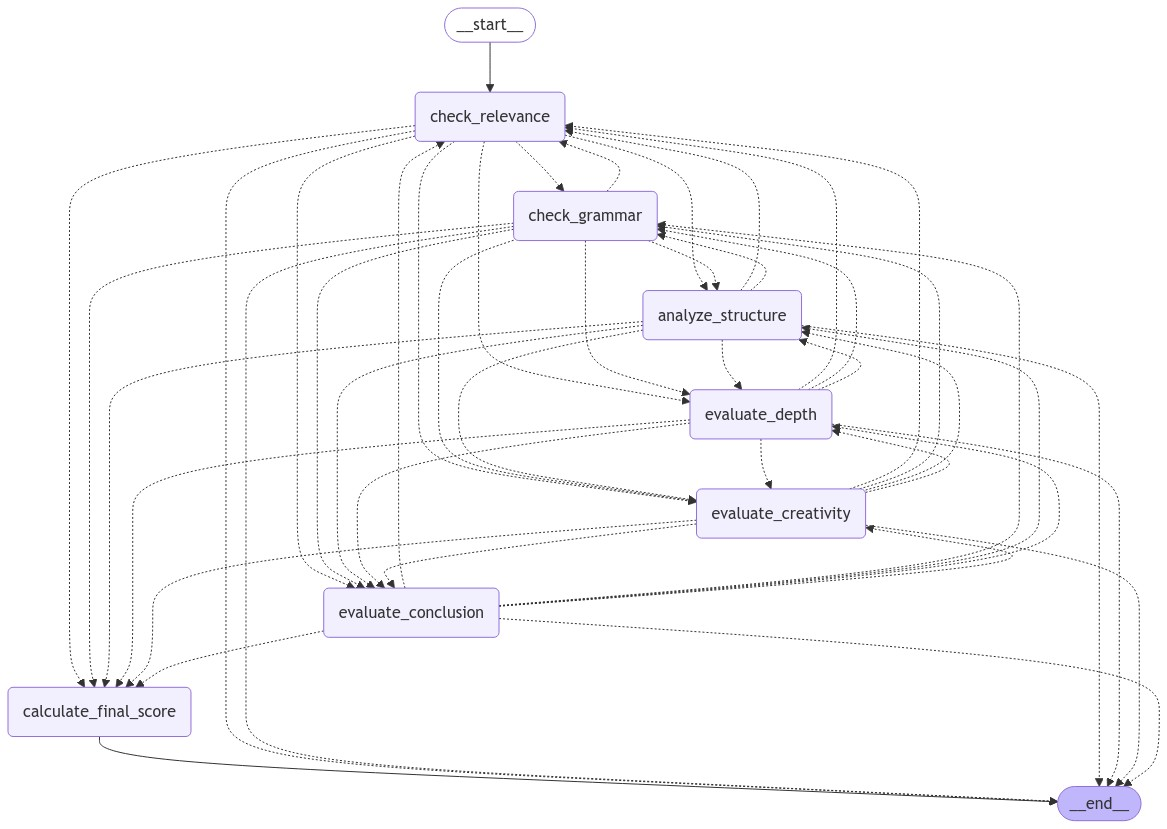

In [8]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [9]:
def grade_essay(essay: str) -> dict:
    """Grade the given essay using the defined workflow."""
    initial_state = State(
        essay=essay,
        relevance_score=0.0,
        grammar_score=0.0,
        structure_score=0.0,
        depth_score=0.0,
        creativity_score=0.0,  # NEW: Initialize creativity score
        conclusion_score=0.0,  # NEW: Initialize conclusion score
        final_score=0.0
    )
    result = app.invoke(initial_state)
    return result

In [12]:
# sample_essay = """
#     The Impact of Artificial Intelligence on Modern Society

#     Artificial Intelligence (AI) has become an integral part of our daily lives,
#     revolutionizing various sectors including healthcare, finance, and transportation.
#     This essay explores the profound effects of AI on modern society, discussing both
#     its benefits and potential challenges.

#     One of the most significant impacts of AI is in the healthcare industry.
#     AI-powered diagnostic tools can analyze medical images with high accuracy,
#     often surpassing human capabilities. This leads to earlier detection of diseases
#     and more effective treatment plans. Moreover, AI algorithms can process vast
#     amounts of medical data to identify patterns and insights that might escape
#     human observation, potentially leading to breakthroughs in drug discovery and
#     personalized medicine.

#     In the financial sector, AI has transformed the way transactions are processed
#     and monitored. Machine learning algorithms can detect fraudulent activities in
#     real-time, enhancing security for consumers and institutions alike. Robo-advisors
#     use AI to provide personalized investment advice, democratizing access to
#     financial planning services.

#     The transportation industry is another area where AI is making significant strides.
#     Self-driving cars, powered by complex AI systems, promise to reduce accidents
#     caused by human error and provide mobility solutions for those unable to drive.
#     In logistics, AI optimizes routing and inventory management, leading to more
#     efficient supply chains and reduced environmental impact.

#     However, the rapid advancement of AI also presents challenges. There are concerns
#     about job displacement as AI systems become capable of performing tasks
#     traditionally done by humans. This raises questions about the need for retraining
#     and reskilling the workforce to adapt to an AI-driven economy.

#     Privacy and ethical concerns also arise with the increasing use of AI. The vast
#     amount of data required to train AI systems raises questions about data privacy
#     and consent. Additionally, there are ongoing debates about the potential biases
#     in AI algorithms and the need for transparent and accountable AI systems.

#     In conclusion, while AI offers tremendous benefits and has the potential to solve
#     some of humanity's most pressing challenges, it also requires careful consideration
#     of its societal implications. As we continue to integrate AI into various aspects
#     of our lives, it is crucial to strike a balance between technological advancement
#     and ethical considerations, ensuring that the benefits of AI are distributed
#     equitably across society.
#     """




sample_essay = """
    Why It Is Much Needed to Stay Calm

    In today's fast-paced world, staying calm has become a vital skill for maintaining
    both mental and physical well-being. The ability to remain composed under pressure
    allows individuals to make better decisions, improve relationships, and manage stress
    effectively.

    Staying calm is particularly important when faced with difficult situations. When
    emotions run high, our ability to think clearly diminishes, leading to impulsive
    decisions that we might later regret. By cultivating a sense of calm, we can better
    assess the situation and respond in a rational, thoughtful manner.

    Additionally, staying calm improves interpersonal relationships. In moments of
    conflict, reacting emotionally can escalate tensions and damage trust. A calm
    approach, on the other hand, fosters constructive communication and promotes problem-solving
    rather than conflict escalation.

    Stress management is another key benefit of maintaining calmness. Chronic stress
    can have serious consequences for physical health, including high blood pressure,
    heart disease, and a weakened immune system. By practicing techniques like deep
    breathing, meditation, and mindfulness, individuals can mitigate the effects of
    stress and enhance their overall well-being.

    In the professional world, calmness is often linked to leadership and success.
    Leaders who maintain their composure are better equipped to handle crises, make
    strategic decisions, and inspire confidence in their teams. This quality allows
    them to navigate challenges with poise and ensure that their organizations remain
    stable during turbulent times.

    In conclusion, staying calm is not just a personal trait; it is an essential skill
    for navigating modern life. By remaining composed in stressful situations, individuals
    can improve their decision-making, enhance relationships, and protect their health.
    In a world that is often chaotic, the ability to stay calm is a powerful tool for
    achieving both personal and professional success.
    """



# sample_essay = """
#     Why It Is Beneficial to Keep Learning in the Tech Industry

#     The technology industry is one of the fastest-evolving sectors in the world, and
#     continuous learning is crucial for anyone wishing to remain relevant and successful
#     in this field. From software development to data science, keeping up with new
#     trends, tools, and innovations can unlock countless opportunities and provide
#     a competitive edge.

#     One of the key reasons why continuous learning is essential in tech is the rapid
#     pace of change. New programming languages, frameworks, and tools are introduced
#     regularly, and older technologies become obsolete. Professionals who are committed
#     to learning new skills stay ahead of these changes, ensuring their expertise
#     remains in demand. For instance, knowledge of cloud computing, artificial
#     intelligence, or cybersecurity can significantly enhance a tech professional’s
#     career prospects.

#     Moreover, continuous learning fosters creativity and innovation. When individuals
#     expand their knowledge base, they can approach problems from new perspectives
#     and devise innovative solutions that set them apart from their peers. Learning
#     about emerging trends like blockchain or machine learning opens doors to
#     pioneering new projects or advancing existing systems in novel ways.

#     Learning also enhances problem-solving skills. The more knowledge you acquire,
#     the better equipped you are to tackle complex challenges. In the tech industry,
#     where problem-solving is a fundamental skill, ongoing education allows professionals
#     to approach issues with a broader toolkit and more confidence.

#     Staying competitive in the job market is another compelling reason to keep learning.
#     Employers in the tech industry value employees who demonstrate a commitment to
#     self-improvement. By showing an ability to learn and adapt to new technologies,
#     candidates increase their chances of landing better positions, promotions, or
#     leadership roles within their organizations.

#     In conclusion, the tech industry rewards those who embrace continuous learning.
#     With new innovations appearing at an unprecedented pace, staying up-to-date with
#     the latest trends and tools is key to long-term success. Continuous learning
#     allows tech professionals to remain competitive, solve complex problems, and
#     bring creative solutions to life.
#     """


In [11]:
# Grade the sample essay
result = grade_essay(sample_essay)

# Display the results
print(f"Final Essay Score: {result['final_score']:.2f}\n")
print(f"Relevance Score: {result['relevance_score']:.2f}")
print(f"Grammar Score: {result['grammar_score']:.2f}")
print(f"Structure Score: {result['structure_score']:.2f}")
print(f"Depth Score: {result['depth_score']:.2f}")
print(f"Creativity Score: {result['creativity_score']:.2f}")  # NEW: Display creativity score
print(f"Conclusion Score: {result['conclusion_score']:.2f}")  # NEW: Display conclusion score


Final Essay Score: 0.55

Relevance Score: 1.00
Grammar Score: 0.95
Structure Score: 0.70
Depth Score: 0.00
Creativity Score: 0.00
Conclusion Score: 0.00
